# Recommender Systems with Python

In this notebook, we will focus on providing a basic recommendation system by suggesting items that are most similar to a particular item, in this case, movies. Keep in mind, this is not a true robust recommendation system, to describe it more accurately,it just tells you what movies/items are most similar to your movie choice.

There is no project for this topic, instead work through the advanced concepts.

## I. Introduction 

There are two common types of **recommender systems**:
1. Collaborative Filtering:
    + Produces recommendations based on the knowledge of users' attitudes towards items
        + in other words, uses "wisdom of the croud" to recommend
        + i.e. online stores suggesting items for you to buy based off of what others are buying
    + More commonly used bc easy to understand and generally better results
2. Content-Based:
    + focuses on the attributes of the items and gives recommendations based on their similarity 
        

### i. Import Libraries

In [1]:
import numpy as np
import pandas as pd

### ii. Get the Data

In [8]:
column_names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('Datasets/u.data', sep='\t', names=column_names)

print(f"Shape of df: {df.shape}")
df.head()

Shape of df: (100003, 4)


,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742


Now let's get the movie titles:

In [4]:
movie_titles = pd.read_csv("Datasets/Movie_Id_Titles")
print(f"Shape of df: {movie_titles.shape}")
movie_titles.head()

Shape of df: (1682, 2)


,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


We can merge them together:

In [9]:
df = pd.merge(df,movie_titles,on='item_id')
print(f"Shape of df: {df.shape}")
df.head()

Shape of df: (100003, 5)


,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)


## II. EDA

Let's explore the data a bit and get a look at some of the best rated movies.

### i. Visualization Imports

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

Let's create a ratings dataframe with average rating and number of ratings:

In [16]:
# Average Rating of each Movie
df.groupby('title')['rating'].mean().sort_values(ascending=False).head()

title
They Made Me a Criminal (1939)                5.0
Marlene Dietrich: Shadow and Light (1996)     5.0
Saint of Fort Washington, The (1993)          5.0
Someone Else's America (1995)                 5.0
Star Kid (1997)                               5.0
Name: rating, dtype: float64

In [17]:
# Number of Ratings per Movie
df.groupby('title')['rating'].count().sort_values(ascending=False).head()

title
Star Wars (1977)             584
Contact (1997)               509
Fargo (1996)                 508
Return of the Jedi (1983)    507
Liar Liar (1997)             485
Name: rating, dtype: int64

In [23]:
# Creating Avg. Rating df
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings.head()

,rating
title,
'Til There Was You (1997),2.333333
1-900 (1994),2.600000
101 Dalmatians (1996),2.908257
12 Angry Men (1957),4.344000
187 (1997),3.024390


Now set the number of ratings column:

In [24]:
ratings['num of ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())
ratings.head()

,rating,num of ratings
title,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41


Now a few **histograms**:

Text(0.5, 1.0, 'Count of the Number of Ratings')

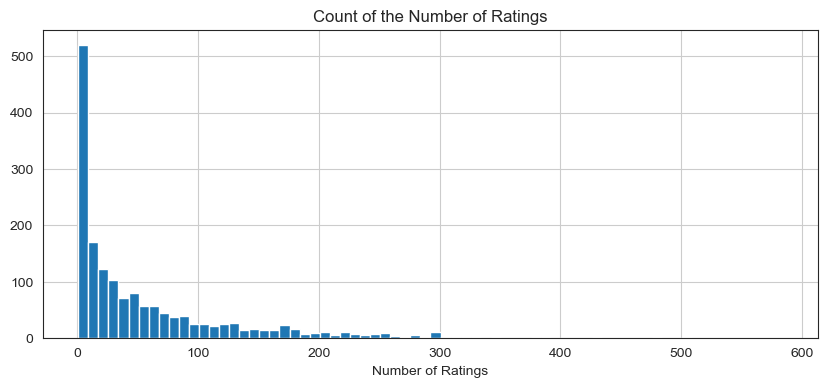

In [25]:
plt.figure(figsize=(10,4))
ratings['num of ratings'].hist(bins=70)
plt.xlabel('Number of Ratings')
plt.title('Count of the Number of Ratings')

Text(0.5, 1.0, 'Count of Ratings')

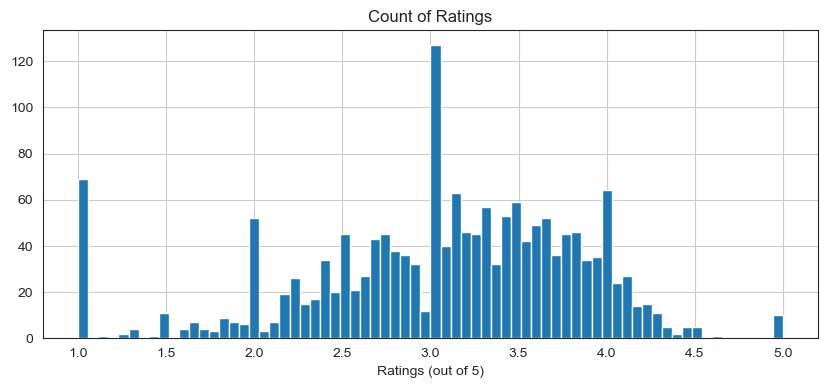

In [26]:
plt.figure(figsize=(10,4))
ratings['rating'].hist(bins=70)
plt.xlabel('Ratings (out of 5)')
plt.title('Count of Ratings')

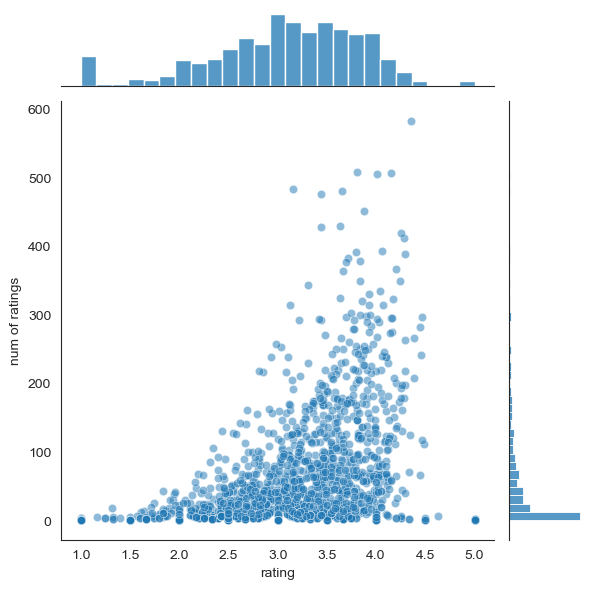

In [27]:
# Ratings Scatterplot
sns.jointplot(x='rating',y='num of ratings',data=ratings,alpha=0.5)

Okay! Now that we have a general idea of what the data looks like. Minus some extremes of very good (5.0) and very bad (1.0) movies having low rating count, the pattern seems that most movies have a low amount of reviews, but the better the ratings the more reviews. This makes sense as people who like a movie will recommend the more and want more people to watch.

With that in mind, lets create a simple recommendation system:

## III.  Recommending Similar Movies

Now let's create a matrix that has... 
- the user ids on one axis and the movie title on another axis
- Each cell will then consist of the rating the user gave to that movie. 
Note: there will be a lot of NaN values, because most people have not seen most of the movies.

In [31]:
movie_mat = df.pivot_table(index='user_id',columns='title',values='rating')

print(f"Movie Matrix Shape: {movie_mat.shape}")
movie_mat.head()

Movie Matrix Shape: (944, 1664)


title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Most rated movie:

In [32]:
ratings.sort_values('num of ratings',ascending=False).head(10)

,rating,num of ratings
title,,
Star Wars (1977),4.359589,584
Contact (1997),3.803536,509
Fargo (1996),4.155512,508
Return of the Jedi (1983),4.007890,507
Liar Liar (1997),3.156701,485
"English Patient, The (1996)",3.656965,481
Scream (1996),3.441423,478
Toy Story (1995),3.878319,452
Air Force One (1997),3.631090,431


Let's choose two movies: <ins>_starwars_</ins>, a sci-fi movie. And <ins>_Liar Liar_</ins>, a comedy.

Now let's grab the user ratings for those two movies:

In [37]:
starwars_user_ratings = moviemat['Star Wars (1977)']
liarliar_user_ratings = moviemat['Liar Liar (1997)']

liarliar_user_ratings.head()

user_id
0    NaN
1    NaN
2    1.0
3    2.0
4    5.0
Name: Liar Liar (1997), dtype: float64

We can then use the `corrwith()` method <ins>to get correlations between two pandas series</ins>:

In [35]:
similar_to_starwars = moviemat.corrwith(starwars_user_ratings)
similar_to_liarliar = moviemat.corrwith(liarliar_user_ratings)

similar_to_liarliar.head()

title
'Til There Was You (1997)    0.118913
1-900 (1994)                      NaN
101 Dalmatians (1996)        0.469765
12 Angry Men (1957)          0.066272
187 (1997)                   0.175145
dtype: float64

Let's **clean** this by <ins>removing NaN values and using a DataFrame</ins> instead of a series:

In [52]:
# Cleaning up Star Wars Correlation
corr_starwars = pd.DataFrame(similar_to_starwars,columns=['Correlation'])
corr_starwars.dropna(inplace=True)

# Cleaning up Liar Liar Correlation
corr_liarliar = pd.DataFrame(similar_to_liarliar,columns=['Correlation'])
corr_liarliar.dropna(inplace=True)
corr_liarliar.head()

,Correlation
title,
'Til There Was You (1997),0.118913
101 Dalmatians (1996),0.469765
12 Angry Men (1957),0.066272
187 (1997),0.175145
2 Days in the Valley (1996),0.040739


Now if we sort the dataframe by correlation, we should get the most similar movies. 

NOTE: we get some results that don't really make sense. This is because there are a lot of movies only watched once by users who also watched star wars (it was the most popular movie). 

In [42]:
corr_starwars.sort_values('Correlation',ascending=False).head(10)

,Correlation
title,
Hollow Reed (1996),1.0
Commandments (1997),1.0
Cosi (1996),1.0
No Escape (1994),1.0
Stripes (1981),1.0
Star Wars (1977),1.0
Man of the Year (1995),1.0
"Beans of Egypt, Maine, The (1994)",1.0
"Old Lady Who Walked in the Sea, The (Vieille qui marchait dans la mer, La) (1991)",1.0


Let's fix this by filtering out movies that have less than 100 reviews (this value was chosen based off the histogram from earlier).

In [46]:
ratings

,rating,num of ratings
title,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41
...,...,...
Young Guns II (1990),2.772727,44
"Young Poisoner's Handbook, The (1995)",3.341463,41
Zeus and Roxanne (1997),2.166667,6


In [53]:
corr_starwars = corr_starwars.merge(ratings['num of ratings'], on='title')
corr_starwars.head()

,Correlation,num of ratings
title,,
'Til There Was You (1997),0.872872,9
1-900 (1994),-0.645497,5
101 Dalmatians (1996),0.211132,109
12 Angry Men (1957),0.184289,125
187 (1997),0.027398,41


Now filter out movies with low review counts and sort the values...

In [54]:
corr_starwars[corr_starwars['num of ratings']>100].sort_values('Correlation',ascending=False).head()

,Correlation,num of ratings
title,,
Star Wars (1977),1.000000,584
"Empire Strikes Back, The (1980)",0.748353,368
Return of the Jedi (1983),0.672556,507
Raiders of the Lost Ark (1981),0.536117,420
Austin Powers: International Man of Mystery (1997),0.377433,130


Now the same for the comedy Liar Liar:

In [55]:
corr_liarliar = pd.DataFrame(similar_to_liarliar,columns=['Correlation'])
corr_liarliar.dropna(inplace=True)
corr_liarliar = corr_liarliar.join(ratings['num of ratings'])
corr_liarliar[corr_liarliar['num of ratings']>100].sort_values('Correlation',ascending=False).head()

,Correlation,num of ratings
title,,
Liar Liar (1997),1.000000,485
Batman Forever (1995),0.516968,114
"Mask, The (1994)",0.484650,129
Down Periscope (1996),0.472681,101
Con Air (1997),0.469828,137
